#  파이토치로 구현한 손글씨 데이터셋 모델

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# 학습 데이터셋을 내려받음
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [9]:
print(training_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
# 데이터로더를 생성, 텐서에서는 데이터 셋
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader :
    print('Shape of X [N, C, H, W] : ', X.shape) #(batch_size, Image num, height, weight)
    print('Shape of y : ', y.shape, y.dtype) #라벨 값
    print(y)
    break

Shape of X [N, C, H, W] :  torch.Size([64, 1, 28, 28])
Shape of y :  torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [11]:
print(len(train_dataloader))
print(len(test_dataloader))

938
157


### 학습에 사용할 CPU장치나 GPU장치를 얻음

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용중인 디바이스 : {}'.format(device))

### 모델을 정의

In [13]:
class NeuralNetwork(nn.Module) :
    def __init__(self) :
        super(NeuralNetwork, self).__init__() # 부모 클래스의 init을 초기화 하면서 NerualNetwork와 self를 인자로 넘겨준다.
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128), # 28*28을 input으로 128개 노드생성
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10) # 128개의 노드를 받고 10개 노드로 output
        )
    
    def forward(self, x) : #callback 함수와 동일
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [15]:
model = NeuralNetwork().to(device) #gpu에 올려라 (device가 gpu일 경우)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


Linear(in_features=784, out_features=128, bias=True)  
bias = True : 해당 in_featurem out_features에 layer는 자동으로 학습함  
bias = False : 해당 in_featurem out_features에 layer는 자동으로 학습하지 않음

### Loss 함수와 Optimizer 설정
#### - parameters() :  iterator 객체를 반환

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

### Trainging을 위한 함수

In [17]:
def train(dataloader, model, loss_fn, optimizer) :
    size = len(dataloader.dataset) #size=60000
    #print("size : ",size)
    for batch, (X, y) in enumerate(dataloader) : # 데이터가 1000개 일때 batch_size가 20이라면 batch(iteration)는 50번, 즉 한번의 batch_size를 통과한 단위
        X, y = X.to(device), y.to(device)
        # 예측 오류 계산
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # 역전파(Back-Propagation)
        #   - 컴퓨터가 예측값의 정확도를 높이기 위해서 출력값과 실제 예측하고자 하는 값을 비교해서 가중치를 변경하는 작업
        #   1. 주어진 입력값에 상관없이 임의의 초기 가중치를 준 뒤 은닉층을 거쳐 결과를 계산
        #   2. 계산 결과와 실제 예측하고자 하는 값 사이의 오차를 구함
        #   3. 가중치 업데이트
        #   4. 1~3의 과정을 오차가 더이상 줄지 않을 때까지 반복
        
        # AI에게 학습이란? 기울기(Gradient)가 가장 작아지는 방향으로 업데이트를 반복하는 것
        # 경사하강법(Gradient Descent)
        # 학습할 때 사용되는 전체 데이터를 미분하여 기울기가 낮은 쪽으로 계속 이동시켜 극값을 구하면 이것을 근사값(예측값)으로 확정하는 원리
        # 한 번 업데이트 할 때마다 전체 데이터를 미분해야 하기 때문에 진행 속도가 느림
        # SGD(확률적 경사 하강법) : 랜덤 추출된 일부 데이터를 사용하여, 오차를 수정하기 전 수정값과 방향(+,-) 참고하고 변경시키는 방법
        
        optimizer.zero_grad() # 오차값이 계속 누적되므로 초기화 시켜준다. 
        loss.backward() # 경사 하강법(최적화) 실행
        optimizer.step() # 기울기 업데이트
        
        if batch % 100 == 0 :
            loss, current = loss.item(), batch * len(X)
            print(f'loss : {loss:>7f} [{current:>5d}/{size:>5d}]')


In [18]:
# Test를 위한 함수
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # size=10000
    num_batches = len(dataloader) 
    # Dropout layer 학습시에만 동작해야 한다.
    model.eval() # 검증하기 위한 레이어만 켜두고 필요없는것들은 꺼둔다. ex) dropout처럼
    test_loss, current = 0, 0
    # autograd를 사용하지 않음으로 메모리 사용량을 줄이고 연산 속도를 높임
    with torch.no_grad() : #gradient 엔진을 끈다.
        for X, y  in dataloader :
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            current += (pred.argmax(1) == y).type(torch.float).sum().item() # 1 아니면 0 이 더해진다.
            
        test_loss /= num_batches 
        current /= size
        print(f'Test Error: \n Accuracy : {(100*current):>0.1f}%, Avg loss : {test_loss:>8f}\n')

In [19]:
epochs = 2
for t in range(epochs) :
    print(f'Epoch {t+1}\---------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print('End')

Epoch 1\---------
loss : 2.302176 [    0/60000]
loss : 0.485847 [ 6400/60000]
loss : 0.303530 [12800/60000]
loss : 0.346717 [19200/60000]
loss : 0.288641 [25600/60000]
loss : 0.314427 [32000/60000]
loss : 0.188067 [38400/60000]
loss : 0.376779 [44800/60000]
loss : 0.251770 [51200/60000]
loss : 0.340760 [57600/60000]
Test Error: 
 Accuracy : 94.2%, Avg loss : 0.197245

Epoch 2\---------
loss : 0.131973 [    0/60000]
loss : 0.218210 [ 6400/60000]
loss : 0.108718 [12800/60000]
loss : 0.223115 [19200/60000]
loss : 0.147579 [25600/60000]
loss : 0.229662 [32000/60000]
loss : 0.065992 [38400/60000]
loss : 0.237977 [44800/60000]
loss : 0.183156 [51200/60000]
loss : 0.242569 [57600/60000]
Test Error: 
 Accuracy : 96.1%, Avg loss : 0.131514

End


#### 파일 불러오기

In [13]:
import os
from PIL import Image
import random

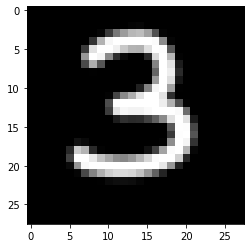

In [14]:
cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, 'image_3.png')

cur_img = Image.open(img_path)
cur_img = cur_img.resize((28, 28))
image = np.asarray(cur_img)

try :
    image = np.mean(image, axis=2) # color image를 gray scale로 바꿀 수 있음
except :
    pass

image = np.abs(255 - image) # 이미지 반전을 시켜준다.
image = image.astype(np.float32) / 255.0 # rescale # 이미지 정규화
plt.imshow(image, cmap='gray')
plt.show()

In [15]:
image = torch.as_tensor(image).to(device).reshape(1, 1, 28, 28) # (batch, 이미지 개수, height, weight)
model.eval() # 테스트할 때 필요없는 레이어의 기능을 끄는 것
predict = model(image)
print('model이 예측한 값은 : {}'.format(predict.argmax(1).item()))

model이 예측한 값은 : 3


In [16]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [17]:
labels_map = {
    0:'T-shart/top', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle boot'
}

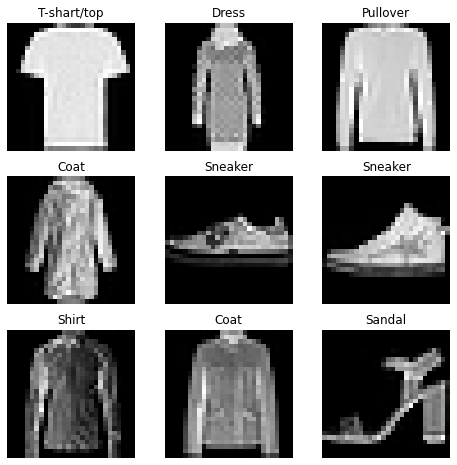

In [18]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows +1) :
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray') # 채널을 없애줌 1을 삭제, 28*28, unsqueeze() 차원을 생성
plt.show()

#### DataLoader 만들기

In [19]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


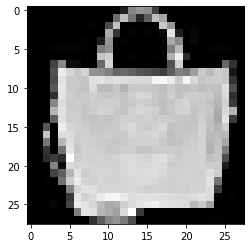

Label: 8


In [20]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape : {train_features.size()}') # (batch, Channel, Height, Width)
print(f'Labels batch shape : {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')

### device 정의하기

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device : {}'.format(device))

using device : cpu


### 모델 클레스 만들기

In [22]:
# Model class 만들기
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 128), 
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### Model 객체 생성

In [23]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


### 가상의 데이터를 만들어서 예측

In [24]:
X = torch.rand(1, 28, 28, device=device) # 1, 28, 28 은 1channel , 28 height, 28 width 
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f'예측된 클래스 : {y_pred}')

예측된 클래스 : tensor([3])


In [25]:
loss_fn = nn.CrossEntropyLoss()

In [26]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [28]:
len(train_dataloader.dataset)

60000

In [29]:
train_dataloader

In [30]:
len(train_dataloader)

938

In [31]:
def train_loop(dataloader, model, loss_fn, optimier) :
    size = len(dataloader.dataset) # 60000
    
    for batch, (X, y) in enumerate(dataloader) : # len(train_dataloader)는 938 , 64x937 + 32 이므로 64 * 938 로 하되 마지막 938번째에는 32개의 데이터만 들어있음
        X, y = X. to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad() # gradient값들을 backward를 해줄 때 게속 값이 누적되기 때문에 loss.backward()를 호출 할 때 
                              #초기설정을 매번 더해주므로 한번의 학습이 끝나면 값을 0으로 초기화 해주기 위해 사용
        loss.backward() # 역전파가 일어남
        optimizer.step() # 기울기 업데이트
        
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss : {loss:>7f} [{current:>5d}/{size:>5d}]')
            
        #if batch == 938 : #그런데 938번째에 대해서는 데이터를 주지 못하고 있다.. 마지막 32개의 데이터는 버리는 것인가? (해결) : 0부터 시작하기 때문에 937이면 938번을 한 것임.
            #print('938번째 배치  : ',batch)
            
    #print('train_batch  : ',batch)

In [32]:
def test_loop(dataloader, model, loss_fn) :
    size = len(dataloader.dataset) # 10000 

    num_batches = len(dataloader)
    test_loss, current = 0, 0
    
    model.eval() # 필요없는 레이어 연산을 막아주고
    
    with torch.no_grad() : # 그레디언트를 막아준다 (메모리 절약)
        for batch, (X, y) in enumerate(dataloader) :
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            current += (pred.argmax(1) == y).type(torch.float).sum().item()
        
    test_loss /= num_batches
    current /= size
    
    print(f'Test Error : \n Accuracy : {(100*current):>0.1f}%, Avg loss : {test_loss:>8f} \n')

### 학습

In [33]:
epochs = 1
for t in range(epochs) :
    print(f'Epoch {t+1}\\------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1\------------
loss : 2.330221 [    0/60000]
loss : 0.760801 [ 6400/60000]
loss : 0.707829 [12800/60000]
loss : 0.436466 [19200/60000]
loss : 0.613348 [25600/60000]
loss : 0.514529 [32000/60000]
loss : 0.437447 [38400/60000]
loss : 0.376853 [44800/60000]
loss : 0.502566 [51200/60000]
loss : 0.515700 [57600/60000]
Test Error : 
 Accuracy : 83.2%, Avg loss : 0.464159 



### 학습된 model parameter 저장

In [34]:
torch.save(model.state_dict(), 'model_weights.pth')

### 새 model instance를 생성

In [35]:
model2 = NeuralNetwork().to(device)
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


### 무작위 가중치에서 학습

In [36]:
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error : 
 Accuracy : 9.1%, Avg loss : 2.318024 



### 저장된 parameter 불러오기

In [37]:
model2.load_state_dict(torch.load('model_weights.pth'))

model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error : 
 Accuracy : 83.2%, Avg loss : 0.466095 



### model 전체를 저장하고 불러오기

In [38]:
torch.save(model, 'model.pth') # 저장
model3 = torch.load('model.pth') # 불러오기

### 테스트

In [39]:
model3.eval()
test_loop(test_dataloader, model3, loss_fn)

Test Error : 
 Accuracy : 83.2%, Avg loss : 0.464990 

